In [1]:
import numpy as np
from iminuit import Minuit
from classy import Class

import functions

import act_dr6_spt_lenslike as apslike
from joblib import Parallel, delayed

n_om = 10
om_min = .05
om_max = 1

n_s8 = 10
s8_min = 0.4
s8_max = 1.2

n_gamma = 10
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

In [32]:
# def chi2_lensing(cl_kk_theory, data_binned_clkk, binmat_act, cinv):
#     model_binned = binmat_act @ cl_kk_theory
#     residual = data_binned_clkk - model_binned
#     return residual.T @ cinv @ residual

variant = 'act_baseline'
lens_only = True # use True if not combining with any primary CMB data
like_corrections = False # should be False if lens_only is True

data_dict = apslike.load_data(variant, lens_only=lens_only, like_corrections=like_corrections)

data = data_dict['data_binned_clkk']
binning_mat = data_dict['binmat_act']
cov_mat_inv = data_dict['cinv']

Loading ACT DR6 lensing likelihood v1.2...


/home/vicpabo/Documents/Projects/Stage-irap/programs/virtual_env/lib/python3.13/site-packages/act_dr6_spt_lenslike/act_dr6_spt_lenslike.py:500: UserWarning: Hartlap correction to cinv: 0.9861635220125786
  warnings.warn(f"Hartlap correction to cinv: {hartlap_correction}")


In [15]:
# print(chi2_lensing(cl_kk_theory, data, binning_mat, cov_mat_inv))
data_dict.keys()
# data_dict['data_binned_clkk']

dict_keys(['include_planck', 'include_spt', 'include_spt_no_planck', 'likelihood_corrections', 'only_spt', 'full_data_binned_clkk_act', 'data_binned_clkk', 'full_binmat_act', 'binmat_act', 'bcents_act', 'full_act_cov', 'cov', 'cinv'])

In [33]:
def find_As_for_sigma8(sigma8_target, h=0.674, omega_b=0.0224, omega_cdm=0.12, n_s=0.965, tau_reio=0.054, 
                       As_min=1e-12, As_max=5e-9, tol=1e-3, max_iter=30):
    """ Dichotomy to find As s.a. sigma8 = sigma8_target.

    Args:
        sigma8_target (int, optional): Defaults to 1.
        h (float, optional): Defaults to 0.674.
        omega_b (float, optional): Defaults to 0.0224.
        omega_cdm (float, optional): Defaults to 0.12.
        n_s (float, optional): Defaults to 0.965.
        tau_reio (float, optional): Defaults to 0.054.
        As_min (_type_, optional): Defaults to 1e-12.
        As_max (_type_, optional): Defaults to 5e-9.
        tol (_type_, optional): Defaults to 1e-3.
        max_iter (int, optional): Defaults to 30.
    """
    def sigma8_for_As(As):
        params = {
            'output': 'lCl, mPk',
            'l_max_scalars': 3000,
            'h': h,
            'omega_b': omega_b,
            'omega_cdm': omega_cdm,
            'n_s': n_s,
            'A_s': As,
            'tau_reio': tau_reio
        }
        
        cosmo = Class()
        cosmo.set(params)
        cosmo.compute()
        sigma8 = cosmo.sigma8()
        cosmo.struct_cleanup()
        cosmo.empty()
        
        return sigma8

    for i in range(max_iter):
        As_mid = 0.5 * (As_min + As_max)
        sigma8_mid = sigma8_for_As(As_mid)

        if abs(sigma8_mid - sigma8_target) < tol:
            return As_mid 

        if sigma8_mid > sigma8_target:
            As_max = As_mid
        else:
            As_min = As_mid

kappa = find_As_for_sigma8(sigma8_target=1, tol=1e-4, max_iter=100)
print("Valeur kappa :", kappa)

Valeur kappa : 3.1009658203125e-09


In [34]:
h=.674
omega_b=.0224
omega_cdm=.120
n_s=.965
tau_reio=.054

binmat = data_dict['binmat_act']
clkk_data = data_dict['data_binned_clkk']
cinv = data_dict['cinv']

A_s_0 = kappa * (.811**2)
A_s_min, A_s_max = kappa * (s8_min**2), kappa * (s8_max**2)

def chi2_lensing(A_s):    

    params = {
        'output': 'lCl',
        'l_max_scalars': 3001,
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'n_s': n_s,
        'A_s': A_s,
        'tau_reio': tau_reio,
    }
    
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    cl = cosmo.raw_cl()
    ell = cl['ell']
    clpp = cl['pp']

    clkk = (ell**2 * (ell + 1)**2) / 4 * clpp
    
    mask = (ell >= 2)
    ell = ell[mask]
    clkk = clkk[mask]
    
    clkk_th_binned = binmat @ clkk
    
    delta = clkk_th_binned - clkk_data
    return delta.T @ cinv @ delta

In [35]:
minimizer = Minuit(chi2_lensing, A_s = A_s_0)
minimizer.limits["A_s"] = (A_s_min, A_s_max)

result = minimizer.migrad()

In [36]:
print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"A_s = {minimizer.values['A_s']:.10f} ± {minimizer.errors['A_s']:.10f}")
print(f"σ8,0 = {np.sqrt(minimizer.values['A_s']/kappa):.10f} ± {np.sqrt(minimizer.errors['A_s']/kappa):.10f}")

print(result)


Résultats du fit :
Chi2 = 534.25 

Paramètres estimés :
A_s = 0.0000000045 ± 0.0000000000
σ8,0 = 1.2000000000 ± 0.0454104551
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 534.3                      │              Nfcn = 33               │
│ EDM = 6.48e-17 (Goal: 0.0002)    │            time = 8.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──

In [ ]:
from time import time

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, H0 = 73.4, M=-19.25)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, H0 = 73.4, M=-19.25)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, H0 = 73.4, M=-19.25)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_rsd_panth_act(omega, sigma, gamma, H0, M):
    return functions.chi2_rsd(omega, sigma, gamma) + functions.chi2_panth(omega, H0, M) + chi2_lensing(kappa * (omega**2))

t = time()

chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_rsd_panth_act) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
np.savez("../output/chi2_lensing/chi2_grid1.npz", grid1=chi2_grid1)
print("chi2_grid1 calculated in", time() - t, "s.")

# chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_rsd_panth_act) for omega in omega_vals for gamma in gamma_vals)
# chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
# np.savez("../output/chi2_lensing/chi2_grid1.npz", grid2=chi2_grid2)
# print("chi2_grid2 calculated in", time() - t, "s.")

chi2_grid2 = np.zeros((n_om, n_gamma))

# chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(omega, gamma, s8_min, s8_max, chi2_rsd_panth_act) for omega in omega_vals for gamma in gamma_vals)
# chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
# np.savez("../output/chi2_lensing/chi2_grid1.npz", grid3=chi2_grid3)
# print("chi2_grid3 calculated in", time() - t, "s.")

chi2_grid3 = np.zeros((n_s8, n_gamma))

chi2_grid1 calculated in 1321.8013520240784 s.


In [3]:
chi2_grid1_loaded = np.load("../output/chi2_lensing/chi2_grid1.npz")['grid1']
# chi2_grid2_loaded = np.load("../output/chi2_lensing/chi2_grid2.npz")['grid2']
# chi2_grid3_loaded = np.load("../output/chi2_lensing/chi2_grid3.npz")['grid3']

chi2_grid2 = np.zeros((n_om, n_gamma))
chi2_grid3 = np.zeros((n_s8, n_gamma))

print(chi2_grid1_loaded)

[[4297.09753348 4290.26746059 4290.02991165 4294.08744194 4301.08136462
  4310.15478419 4320.73979329 4332.44557381 4344.99481609 4358.18574667]
 [3538.71052363 3513.66437466 3501.45300051 3497.89319714 3500.41317111
  3507.33618108 3517.51995267 3530.15936866 3544.6713712  3560.62435281]
 [3214.95269888 3177.60976651 3156.94596698 3147.7187753  3146.6337093
  3151.50244896 3160.81013639 3173.47428924 3188.70157109 3205.89884366]
 [3168.54944256 3121.68826432 3094.35952325 3080.52036389 3076.36990235
  3079.35071825 3087.67311399 3100.04590663 3115.51533644 3133.36325175]
 [3334.60672415 3263.68389178 3230.84479497 3213.11133224 3206.29779619
  3207.56029107 3214.89226988 3226.83634145 3242.30978401 3261.1013744 ]
 [3657.9721939  3553.54828543 3516.01475655 3494.91308278 3485.75004595
  3485.44836683 3491.82288291 3506.06934453 3551.84791646 3634.8209241 ]
 [4095.95776629 3962.49378708 3916.81400936 3892.74711431 3881.48522851
  3879.754536   3904.80149312 3978.0554689  4099.53647175 4

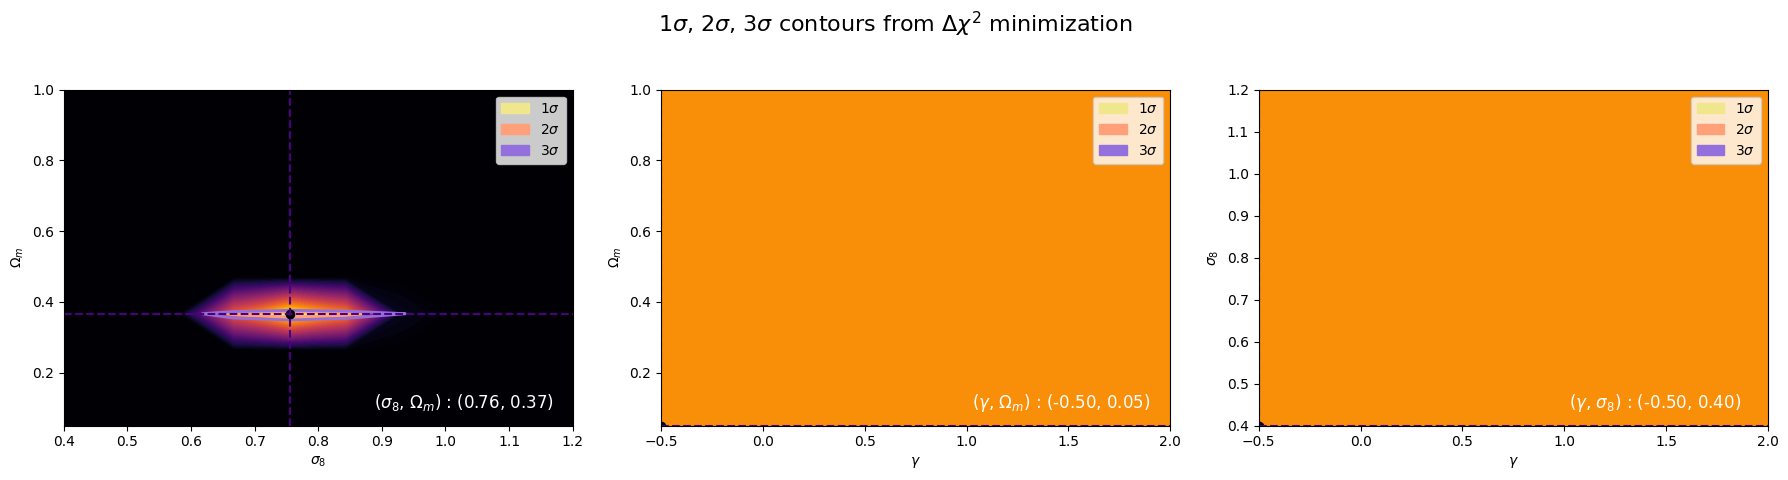

In [4]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=12,
                verticalalignment='top', horizontalalignment='left')


        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization", fontsize=16)
display_all_chi2([chi2_grid1_loaded, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

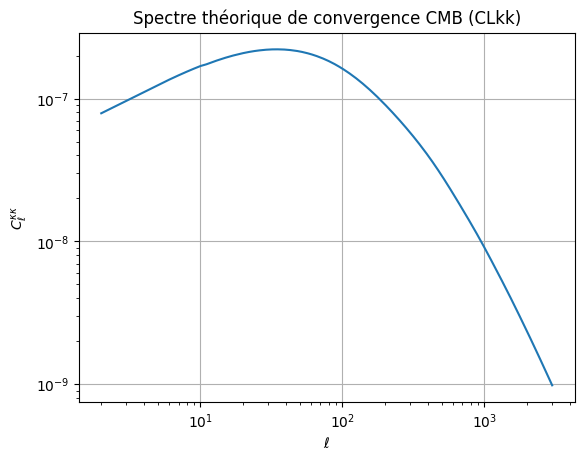

In [11]:
from matplotlib import pyplot as plt

params = {
    'output': 'tCl,pCl,lCl',
    'l_max_scalars': 2999,       # Maximum multipole à calculer
    'h': 0.674,                  # H0/100
    'omega_b': 0.0224,           # Densité baryonique
    'omega_cdm': 0.120,          # Densité matière noire
    'A_s': 2.1e-9,               # Amplitude du spectre primordial
    'n_s': 0.965,                # Indice spectral
    'tau_reio': 0.054,           # Profondeur optique
}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

cl = cosmo.raw_cl()
ells = cl['ell']
clpp = cl['pp']

clkk = (ells**2 * (ells + 1)**2) / 4 * clpp

mask = ells >= 2
ells = ells[mask]
clkk = clkk[mask]

# (facultatif) Afficher
plt.loglog(ells, clkk)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\kappa\kappa}$')
plt.title("Spectre théorique de convergence CMB (CLkk)")
plt.grid()
plt.show()

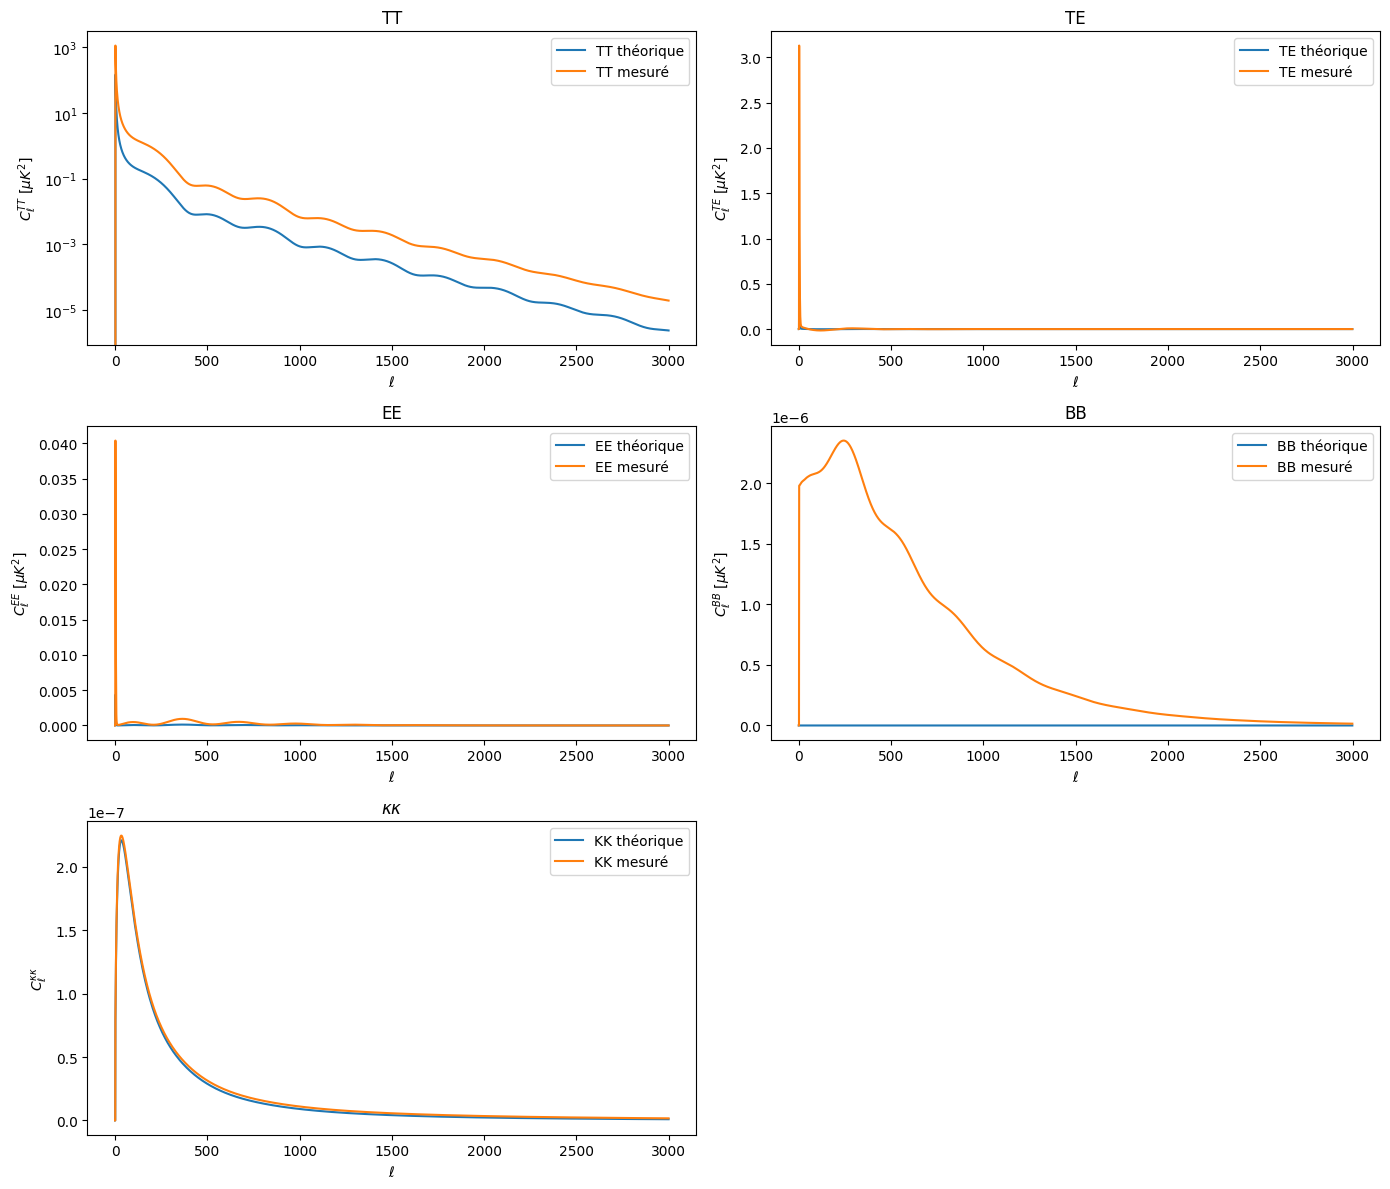

In [42]:
params = {
    'output': 'tCl,pCl,lCl',
    'l_max_scalars': 2999,       # Maximum multipole à calculer
    'h': 0.674,                  # H0/100
    'omega_b': 0.0224,           # Densité baryonique
    'omega_cdm': 0.120,          # Densité matière noire
    'A_s': 2.1e-9,               # Amplitude du spectre primordial
    'n_s': 0.965,                # Indice spectral
    'tau_reio': 0.054,           # Profondeur optique
}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

cl = cosmo.raw_cl()

ells = cl['ell']
cltt = cl['tt'] * 1e12      # K^2 -> μK^2
clte = cl['te'] * 1e12
clee = cl['ee'] * 1e12
clbb = cl['bb'] * 1e12

clphiphi = cl['pp']
clkk = (ells**2 * (ells+1)**2 / 4.) * clphiphi

fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# TT
axs[0, 0].plot(ells, cltt, label="TT théorique")
axs[0, 0].plot(ells, data_dict['fiducial_cl_tt'], label="TT mesuré")
axs[0, 0].set_xlabel(r'$\ell$')
axs[0, 0].set_ylabel(r'$C_\ell^{TT}$ [$\mu K^2$]')
axs[0, 0].set_title('TT')
axs[0, 0].set_yscale('log')
axs[0, 0].legend()

# TE
axs[0, 1].plot(ells, clte, label="TE théorique")
axs[0, 1].plot(ells, data_dict['fiducial_cl_te'], label="TE mesuré")
axs[0, 1].set_xlabel(r'$\ell$')
axs[0, 1].set_ylabel(r'$C_\ell^{TE}$ [$\mu K^2$]')
axs[0, 1].set_title('TE')
axs[0, 1].legend()

# EE
axs[1, 0].plot(ells, clee, label="EE théorique")
axs[1, 0].plot(ells, data_dict['fiducial_cl_ee'], label="EE mesuré")
axs[1, 0].set_xlabel(r'$\ell$')
axs[1, 0].set_ylabel(r'$C_\ell^{EE}$ [$\mu K^2$]')
axs[1, 0].set_title('EE')
axs[1, 0].legend()

# BB
axs[1, 1].plot(ells, clbb, label="BB théorique")
axs[1, 1].plot(ells, data_dict['fiducial_cl_bb'], label="BB mesuré")
axs[1, 1].set_xlabel(r'$\ell$')
axs[1, 1].set_ylabel(r'$C_\ell^{BB}$ [$\mu K^2$]')
axs[1, 1].set_title('BB')
axs[1, 1].legend()

# KK
axs[2, 0].plot(ells, clkk, label="KK théorique")
axs[2, 0].plot(ells, data_dict['fiducial_cl_kk'], label="KK mesuré")
axs[2, 0].set_xlabel(r'$\ell$')
axs[2, 0].set_ylabel(r'$C_\ell^{\kappa\kappa}$')
axs[2, 0].set_title(r'$\kappa\kappa$')
axs[2, 0].legend()

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

cosmo.struct_cleanup()
cosmo.empty()

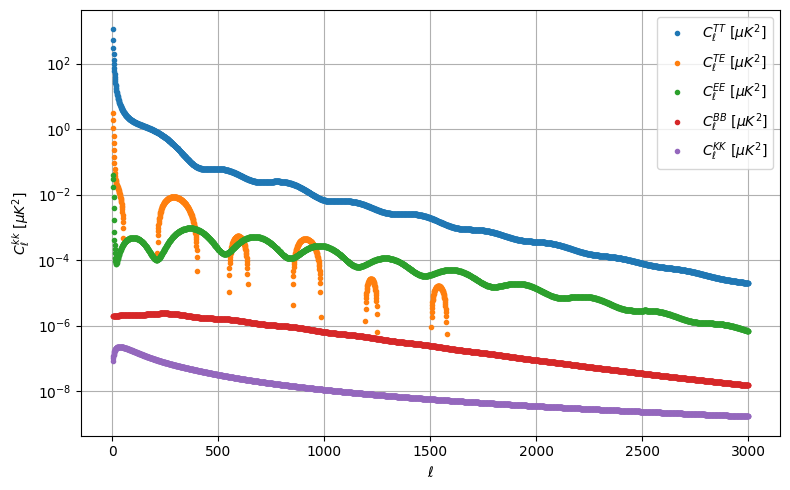

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def display_cl(cl, key):
    plt.errorbar(np.arange(len(cl)), cl, fmt='.', capsize=2, label=r"$C_\ell^{%s}$ [$\mu K^2$]" % key)

plt.figure(figsize=(8,5))
display_cl(data_dict['fiducial_cl_tt'], 'TT')
display_cl(data_dict['fiducial_cl_te'], 'TE')
display_cl(data_dict['fiducial_cl_ee'], 'EE')
display_cl(data_dict['fiducial_cl_bb'], 'BB')
display_cl(data_dict['fiducial_cl_kk'], 'KK')

plt.yscale('log')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{%s}$ [$\mu K^2$]" % "kk")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
